In [3]:
from notebook.services.config import ConfigManager
cm = ConfigManager()

cm.update('livereveal', {
              'width': 1000,
              'height': 600,
              'scroll': True,
})

{'width': 1000, 'height': 600, 'scroll': True}

# Setting up The Program

Here, all the imports used in the program are set, reducing redundancies within the code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
from scipy import stats
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import ipywidgets as widgets
import pandas_datareader
import datetime
import pandas_datareader.data as web
import yfinance as yf

from matplotlib.pyplot import figure

from mpl_finance import candlestick_ohlc
from matplotlib.dates import DateFormatter, date2num, WeekdayLocator, DateLocator, MONDAY

from bokeh.plotting import figure, show, output_file

from newsapi import NewsApiClient
import json

from textblob import TextBlob

from monkeylearn import MonkeyLearn

import requests

# Enter Stock Information Here
    - Input ticker symbol for the stock you want to analyze
    - Gives you the stock and a comparison stock fund for the user-inputted stock
    - Compares the stock using multiple indicators
        - Sentiment Analysis of news headlines related to that company to determine correlation between news and stock price
        - Alpha / Beta rating to determine risk of investment and excess return on an investment compared to an index (S8&P 500, etc.)


In [25]:
stock1 = widgets.Text() #used to get the user input for the ticker symbol
stock2 = widgets.Text()
stock3 = widgets.Text()
box = widgets.VBox([stock1,stock2,stock3])
box

In [29]:
stocks1 = yf.Ticker(stock1.value)  #gets the data live form yahoo finance
stocks2 = yf.Ticker(stock2.value)
stocks3 = yf.Ticker(stock3.value)

stocks1.history(period="max") #stock histoy for the first company

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29,19.00,25.00,17.54,23.89,18766300,0,0
2010-06-30,25.79,30.42,23.30,23.83,17187100,0,0
2010-07-01,25.00,25.92,20.27,21.96,8218800,0,0
2010-07-02,23.00,23.10,18.71,19.20,5139800,0,0
2010-07-06,20.00,20.00,15.83,16.11,6866900,0,0
...,...,...,...,...,...,...,...
2020-02-13,741.84,818.00,735.00,804.00,26289300,0,0
2020-02-14,787.22,812.97,785.50,800.03,15693700,0,0
2020-02-18,841.60,860.00,832.36,858.40,16381700,0,0


In [30]:
first_company_name = stocks1.info['shortName'].lower().split(" ")
first_company_name[0]

'tesla,'

# Sentiment Analysis

Gets news headlines for stock that the user inputted using NEWSAPI

Feeds the news headlines into monkeylearn to analyze for sentiment analysis

Determines a correlation between sentiment analysis and stock price

In [31]:
# Init
newsapi = NewsApiClient(api_key='90ea3a917ab743ef925def71bb5b5c30')

#top_headlines
top_headlines = newsapi.get_top_headlines(q=first_company_name[0],
#                                           sources='bbc-news,the-verge',
                                          category='business',
                                          language='en',
                                          country='us')

# everything
all_articles = newsapi.get_everything(q=first_company_name[0],
                                      sources='bbc-news,the-verge',
                                      domains='bbc.co.uk,techcrunch.com',
                                      from_param='2020-01-20',
                                      to='2020-02-19',
                                      language='en',
                                      sort_by='relevancy',
                                      page=2)

#sources
sources = newsapi.get_sources()

In [32]:
x = len(all_articles['articles'])
cnt = 0

all_top_headlines = ""


while(cnt < x):
    all_top_headlines += all_articles['articles'][cnt]['title']
    cnt = cnt + 1

all_top_headlines

'Tim Draper puts $1M into the Aragon blockchain project to create digital courtsThe Station: Lucid Motors spy shot and the birth of an AV startupThe new Cadillacs are getting automatic lane-changing, thanks to updated Super CruiseZero Motorcycles unveils new SR/S — a full-fairing 124 mph sport EVOpera and the firm short-selling its stock (alleging Africa fintech abuses) weigh inTesla shares jump on profitable quarter, Model Y productionTesla calls claims of unintended acceleration in NHTSA petition "completely false"Tesla could soon sell and service its vehicles in MichiganTesla is going back to the markets to raise more than $2 billion through stock offeringTesla ramps up solar tile roofs installations in U.S., eyes China and Europe expansionCoronavirus: Thousands stuck on cruise ship after suspected caseWell, Bill Gates is never going to buy a Tesla nowEquity shot: What\'s going on with Tesla\'s stock price?Elon Musk says all advanced AI development should be regulated, including at 

### Polarity vs Subjectivity

Polarity is a float between [-1,1], where 1 means a positive statement and -1 means a negative statement.

Subjectivity refers to personal opinion, emotion, or judgement and is a value in the range [0,1]

In [33]:
from textblob import TextBlob

text = all_top_headlines

blob = TextBlob(text)

for sentence in blob.sentences:
    print(sentence.sentiment)

Sentiment(polarity=0.056161616161616155, subjectivity=0.37202020202020203)


#### MonkeyLearn - Machine Learning 

I used the MonkeyLearn API which uses Machine Learning and Natural Language Processing to determine the sentiment of the news headlines.

I made a custom model tailored to my data to get results of the sentiment

In [34]:
from monkeylearn import MonkeyLearn
 
ml = MonkeyLearn('990d0e6ae6b3a3be92701c33abb34b222cf32e27')
data = [all_top_headlines]
model_id = 'cl_pi3C7JiL'
result = ml.classifiers.classify(model_id, data)

print(result.body[0]['classifications'][0]['tag_name'])
print("{}% confidence".format(((result.body[0]['classifications'][0]['confidence'])*100)))

Negative
65.5% confidence


In [35]:
#gets the sector of the stock that you input and a top-performing fund to compare it with
def getSectorFund(sector):
    switcher={
            'Basic Materials':'IGE',
            'Financial Services':'IXF',
            'Consumer Defensive':'XLP',
            'Utilities':'XLU',
            'Energy':'XLE',
            'Technology':'^IXIC',
            'Consumer Cyclical':'XLY', ##^SPSDYUN
            'Real Estate':'TIREX',
            'Healthcare':'^GSPC',
            'Communication Services':'FIUIX',
            'Industrials':'FSDAX'
         }
    return switcher.get(sector,"Invalid stock")

In [36]:
sector1 = (getSectorFund(stocks1.info['sector'])) #Prints the name of a sector fund that the company the user inputted is in
sector2 = (getSectorFund(stocks2.info['sector']))
sector3 = (getSectorFund(stocks3.info['sector']))

sector1

'XLY'

In [37]:
stocks1.history(period="max")['Close']

Date
2010-06-29     23.89
2010-06-30     23.83
2010-07-01     21.96
2010-07-02     19.20
2010-07-06     16.11
               ...  
2020-02-13    804.00
2020-02-14    800.03
2020-02-18    858.40
2020-02-19    917.42
2020-02-20    892.04
Name: Close, Length: 2428, dtype: float64

In [38]:
#Scatter matrix plot of all the closing prices
from pandas.plotting import scatter_matrix

In [39]:
input_comp = pd.concat([stocks1.history(period="max")['Close'], 
                      stocks2.history(period="max")['Close'], 
                      stocks3.history(period="max")['Close']], 
                      axis=1)
input_comp.columns = [stock1.value + " Close", stock2.value + " Close", stock3.value + " Close"]

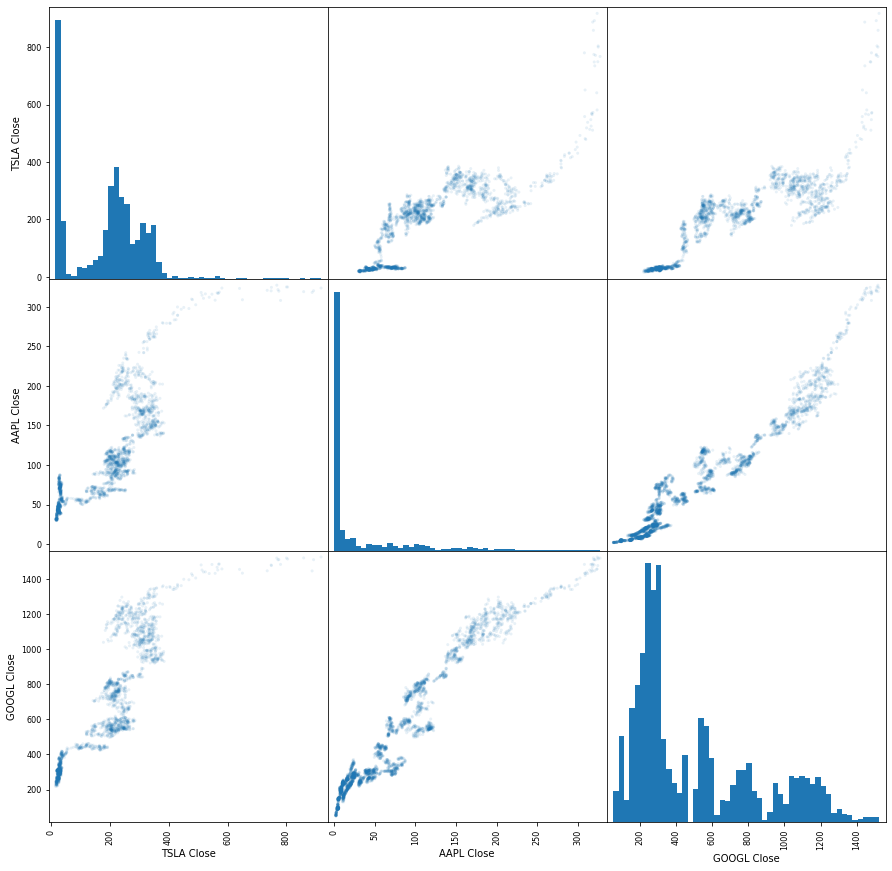

In [40]:
scatter_matrix(input_comp, figsize=(15,15), alpha=0.1, hist_kwds={'bins':50});



When Intel goes up, NVDA also tends to go up.

When MVDA goes up, AMD also tends to go up.

In [41]:
stocks1.history(period="max")
stocks2.history(period="max")
stocks3.history(period="max")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-08-19,50.05,52.08,48.03,50.22,44659000,0,0.0
2004-08-20,50.56,54.59,50.30,54.21,22834300,0,0.0
2004-08-23,55.43,56.80,54.58,54.75,18256100,0,0.0
2004-08-24,55.68,55.86,51.84,52.49,15247300,0,0.0
2004-08-25,52.53,54.05,51.99,53.05,9188600,0,0.0
...,...,...,...,...,...,...,...
2020-02-13,1510.00,1525.95,1504.00,1513.39,1145700,0,0.0
2020-02-14,1514.53,1520.05,1505.55,1518.73,1159900,0,0.0
2020-02-18,1514.34,1530.56,1511.01,1519.44,1282100,0,0.0


In [42]:
#Setes the start and end time for the dates of the stock to be analyzed.
#Gets the data  from yahoo finance

start = datetime.datetime(2012,2,25)
end = datetime.datetime(2020,2,19)
f_stocks1 = web.DataReader(stock1.value,'yahoo',start,end)
comparison_stock = web.DataReader(getSectorFund(stocks1.info['sector']),'yahoo',start,end)

In [43]:
#Graphing candlestick chart for the stock that the user input and a fund for the sector of the stock that the user input
from mpl_finance import candlestick_ohlc
from matplotlib.dates import DateFormatter, date2num, WeekdayLocator, DateLocator, MONDAY


import pandas as pd
import pandas_datareader as web
from bokeh.plotting import figure, show, output_file

user_stock = web.get_data_yahoo(stock1.value,start = "2015-03-01", end = "2020-02-19")

user_stock['date'] = pd.to_datetime(user_stock.index)
# This is to color the red and green bars for Down and up days
increase = user_stock['Close'] > user_stock["Open"]
decrease = user_stock['Open'] > user_stock["Close"]
# w is used to specify the width of each bar
w = 12*60*60*1000
# Tools we want on our chart such as zoom, save etc
tools = "pan,box_zoom,reset,save"
# p is our figure or plot
p = figure(x_axis_type = "datetime", tools = tools, plot_width = 1800, title = stock1.value + " CandleStick Chart")
# Shows the grid line traperency
p.grid.grid_line_alpha=0.3
# Adding Vertical lines on the cheart each day
p.segment(user_stock.date, user_stock.High, user_stock.date, user_stock.Low, color="black")
# Adding the bars on each line and specifying the width as w
# Coloring up days as Green
p.vbar(user_stock.date[increase], w, user_stock.Open[increase], user_stock.Close[increase], fill_color="#D5E1DD", line_color="black")
# Coloring down days as Red
p.vbar(user_stock.date[decrease], w, user_stock.Open[decrease], user_stock.Close[decrease], fill_color="#F2583E", line_color="black")
# Saving the file as candlestick.html
output_file("candlestick.html", title="candlestick.py example")
show(p)

# Graphs User-Stock vs. Comparison Index

Compares the stock the user inputted with a fund from that same sector

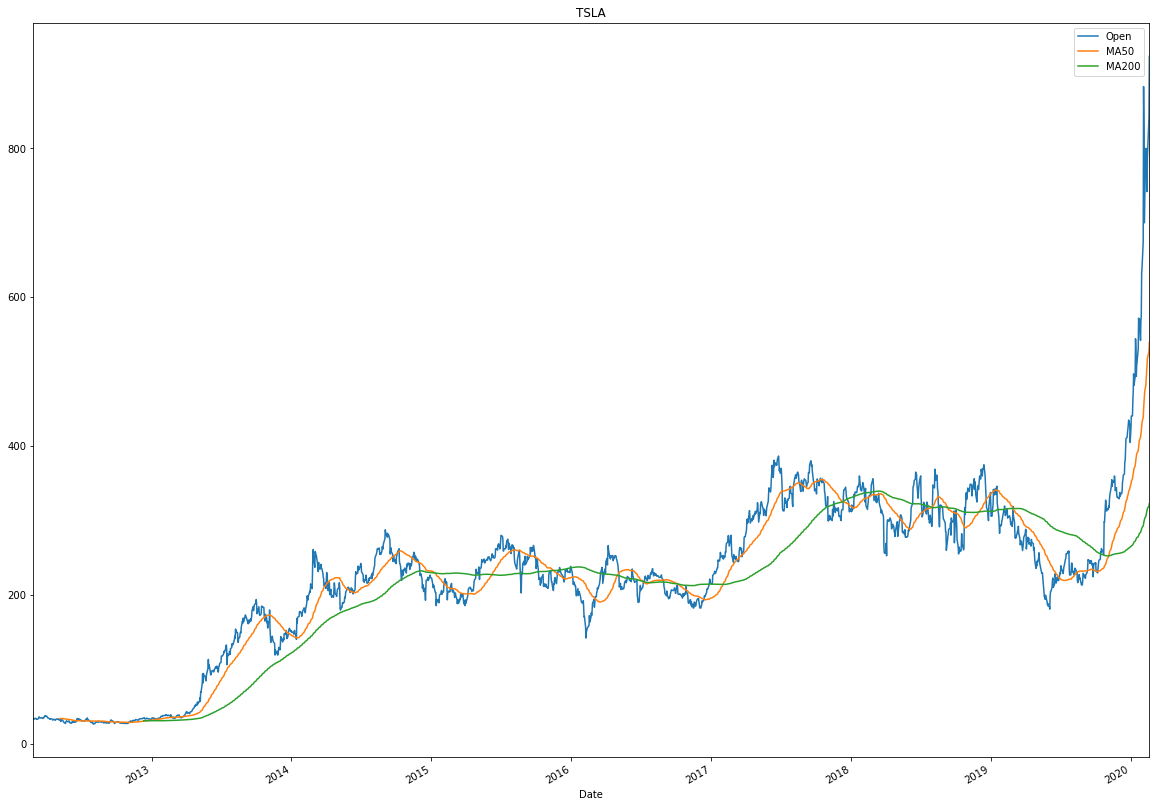

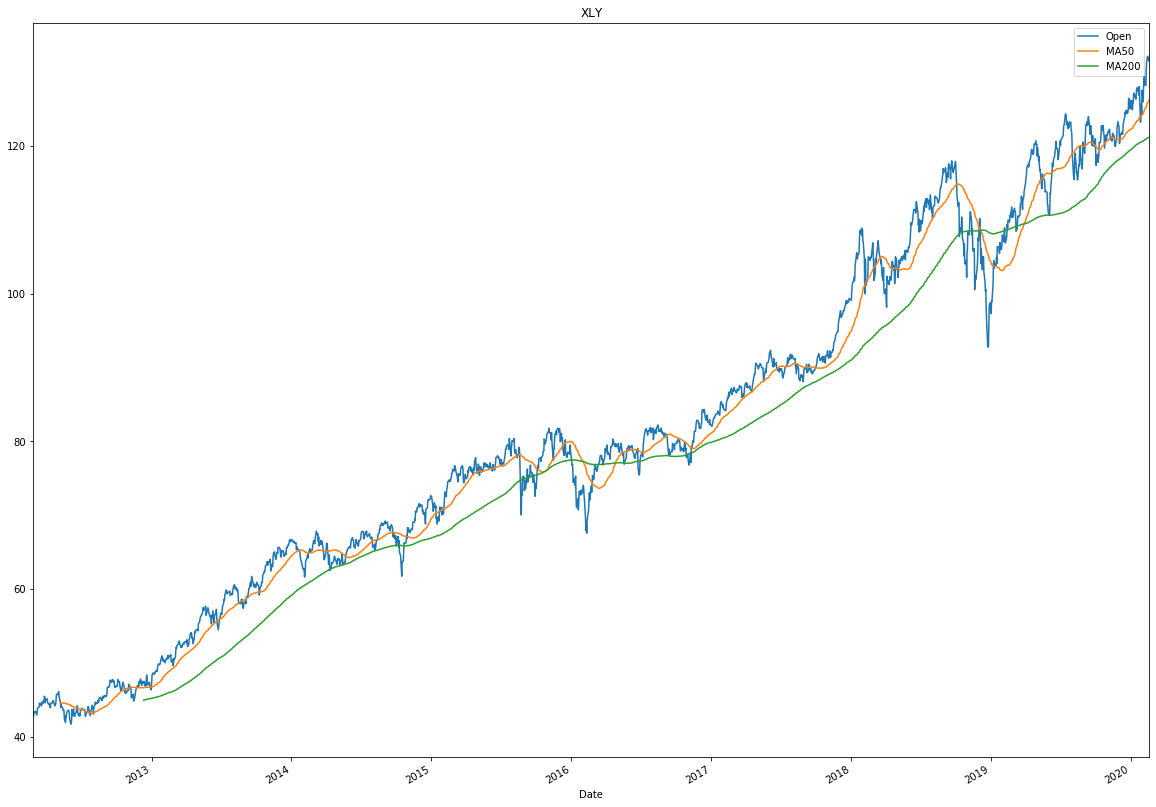

In [44]:
#Graphing the moving averages for the stock that the user input and a fund for the sector of the stock that the user input
#When the open line is higher than the MA line, buy. Vice-versa
f_stocks1['MA50'] = f_stocks1['Open'].rolling(50).mean()
f_stocks1['MA200'] = f_stocks1['Open'].rolling(200).mean()
f_stocks1[['Open', 'MA50', 'MA200']].plot(label=stock1.value, figsize=(20,15),title=stock1.value) #check this

comparison_stock['MA50'] = comparison_stock['Open'].rolling(50).mean()
comparison_stock['MA200'] = comparison_stock['Open'].rolling(200).mean()
comparison_stock[['Open', 'MA50', 'MA200']].plot(label=getSectorFund(stocks1.info['sector']), figsize=(20,15),title=getSectorFund(stocks1.info['sector']))

plt.legend();

In [45]:
if f_stocks1['MA50'][-1] > f_stocks1['MA200'][-1]:
    print("Buy")
    
if comparison_stock['MA50'][-1] > comparison_stock['MA200'][-1]:
    print("Buy")

Buy
Buy


# Alpha/Beta rating of User Stock Compared to Sector Stock

Calculates the Alpha and Beta rating of the stock using the comparison stock as the index/etf of the sector the user stock is in 

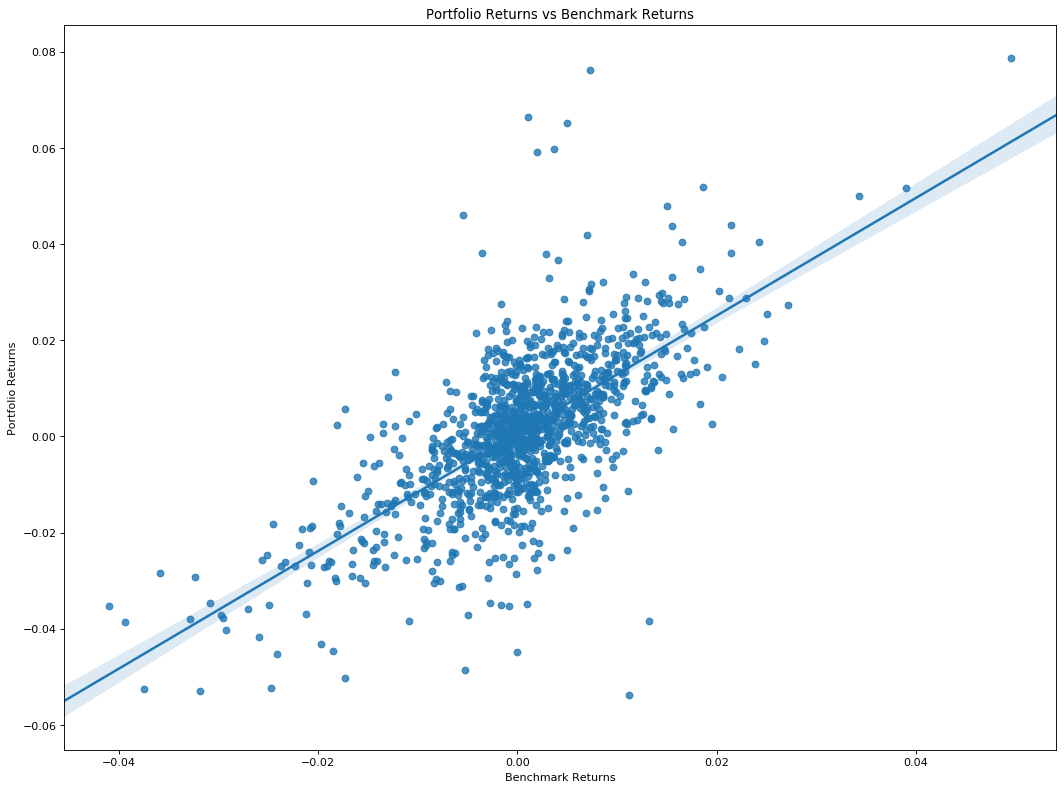

In [46]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')

tickers = [stock1.value,stock2.value,stock3.value]
wts = [0.33,0.33,0.33] #shows how much of the portfoloi was invested in each stock

price_data = web.get_data_yahoo(tickers,
                               start = '2015-01-01',
                               end = '2020-02-19')
price_data = price_data['Adj Close']

ret_data = price_data.pct_change()[1:]

port_ret = (ret_data * wts).sum(axis = 1)

benchmark_price = web.get_data_yahoo("^GSPC",
                               start = '2015-01-01',
                               end = '2020-02-19')
                               
benchmark_ret = benchmark_price["Adj Close"].pct_change()[1:]

sns.regplot(benchmark_ret.values,
port_ret.values)
plt.xlabel("Benchmark Returns")
plt.ylabel("Portfolio Returns")
plt.title("Portfolio Returns vs Benchmark Returns")

plt.show()

## Correlation between company and sector in Graph
The graph shows that there is a strong correlation between how the company performs based on the sector's overall performance

In [47]:
(beta, alpha) = stats.linregress(benchmark_ret.values,
                port_ret.values)[0:2]
                
print("The portfolio beta is", round(beta, 4)*100 ,"%")

print("The portfolio alpha is", round(alpha,5)*100 ,"%")


The portfolio beta is 122.30000000000001 %
The portfolio alpha is 0.064 %


### The Beta rating of the stock shows how much the individual company's stock price will increase compared to the sector

For example: If the Beta rating was 100%, for every 1 point the sector rose the individual company's stock price would also increase by 1 point